In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [2]:
ames = pd.read_csv("/Users/AustinLiu/Desktop/GSB544-ComputingandMachineLearning/In-Class-Data/AmesHousing.csv")
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

# Part 1

In [4]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

We drop the columns Order and PID because we dont want these as predictors. Labeling or ID column does not add to the analysis. <br>

Handle_unknown: When we have categorical variables with rare categories. When we split test and train, there is a chance that they all end up in train or test. 

In [5]:
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-9.99458619e+19, -2.83178235e+20, -4.53259644e+21, -4.29881496e+21,
       -8.52122515e+22])

In [6]:
ridge_pipeline = Pipeline(
[("preprocessing", ct),
("ridge_regression", Ridge(alpha = 1))]
)

cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = "r2")

array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

In [7]:
ridge_pipeline_fitted = ridge_pipeline.fit(X, y)

y_pred = ridge_pipeline_fitted.predict(X)
ridgecoef = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_

In [8]:
lr_fitted = lr_pipeline_1.fit(X, y)
Y_pred_lr = lr_fitted.predict(X)
lrcoef =lr_fitted.named_steps['linear_regression'].coef_

In [9]:
plotdata = pd.DataFrame({"Ridge":ridgecoef, "LR":lrcoef})
plotdata

,Ridge,LR
0,-5740.055372,5.511873e+16
1,1511.928887,5.511873e+16
2,-5809.704488,5.511873e+16
3,7676.327583,5.511873e+16
4,3215.393618,5.511873e+16
...,...,...
254,2937.762099,2.651500e+03
255,1377.194605,2.720000e+03
256,-4485.971545,-5.264000e+03
257,-674.189275,-7.360000e+02


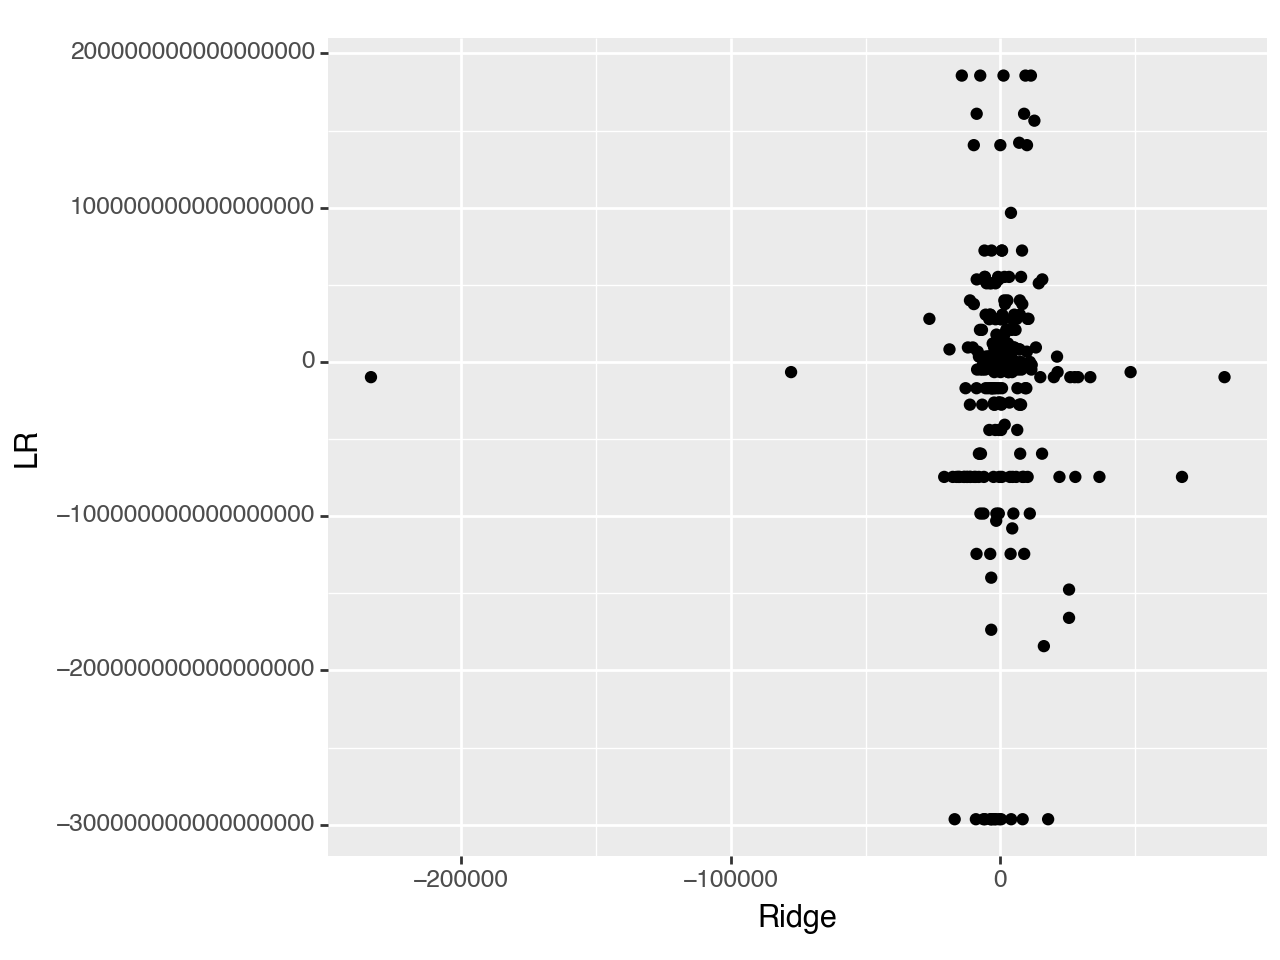

<Figure Size: (640 x 480)>

In [10]:
from plotnine import *

(ggplot(plotdata, aes(x = "Ridge", y = "LR"))
+ geom_point())
#+ coord_cartesian(xlim = (-25000, 25000), ylim = (-10000, 10000)))

# Part 2

In [11]:
from sklearn.model_selection import GridSearchCV

#Part in the Pipeline and the parameter of interest
ridge_pipeline = Pipeline(
[("preprocessing", ct),
("ridgeregression", Ridge())]
)

lambdas = {"ridgeregression__alpha": [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring='r2')

In [12]:
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"alpha": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_["mean_test_score"]})

,alpha,scores
0,0.001,0.852945
1,0.010,0.853224
2,0.100,0.855423
3,1.000,0.861159
4,10.000,0.863355


# Part 3

In [13]:
lasso_pipeline = Pipeline(
[("preprocessing", ct),
("lasso", Lasso())]
)

alphas = {"lasso__alpha": [0, 0.001, 0.01, 0.1, 1]}

gscv1 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring = "r2")

In [14]:
gscv1_fitted = gscv1.fit(X, y)
pd.DataFrame(data = {"alpha": [0, 0.001, 0.01, 0.1, 1], "scores": gscv1_fitted.cv_results_["mean_test_score"]})

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.191e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWa

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+11, tolerance: 1.463e+09
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+11, tolerance: 1.407e+09
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+11, tolerance: 1.477e+09
/Users/AustinLiu/anaconda3/lib/pyt

,alpha,scores
0,0.000,0.854427
1,0.001,0.854440
2,0.010,0.854549
3,0.100,0.855394
4,1.000,0.855890


In [15]:
lasso_pipeline_fitted = lasso_pipeline.fit(X, y)

y_pred = lasso_pipeline_fitted.predict(X)
lassocoef = lasso_pipeline_fitted.named_steps['lasso'].coef_

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+10, tolerance: 1.793e+09


In [16]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.001, 0.01, 0.1]}

gscv2 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='r2')

In [18]:
gscv2_fitted = gscv2.fit(X, y)
pd.DataFrame(data = {"scores": gscv2_fitted.cv_results_["mean_test_score"]})

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+11, tolerance: 1.348e+09
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+11, tolerance: 1.474e+09
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.083e+11, tolerance: 1.463e+09
/Users/AustinLiu/anaconda3/lib/pyt

,scores
0,0.862388
1,0.862378
2,0.862264
3,0.862745
4,0.862760
5,0.862903
6,0.851332
7,0.851408
8,0.852189
9,0.811881
